This notebook is about interpretation of ML models. The first part is about interpretable models (logistic regression and decision trees). The second part is about model-agnostic methods (PMF, PDP, ICE, LIME, SHAP). There are two Medium articles about the notebook.

Article about interpretable ml models:
https://medium.com/@hennie_de_harder/interpretable-machine-learning-models-aef0c7be3fd9?source=friends_link&sk=7a243747d5c480b1d9df5150a2257a2f

Article about model-agnostic methods:
https://medium.com/@hennie_de_harder/model-agnostic-methods-for-interpreting-any-machine-learning-model-4f10787ef504?source=friends_link&sk=6b7431f4562e2885a99ace5687c4d60d

# Preparing the data

import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import StandardScaler

from pdpbox import pdp, get_dataset, info_plots
import shap
import lime
from lime import lime_tabular

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import eli5
from eli5.sklearn import PermutationImportance

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


import and preprocess data

In [2]:
data = pd.read_csv('heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
cols_meaning = ['age of patient', '1 = male, 0 = female', 'chest pain type', 'resting blood pressure (in mm Hg on admission to the hospital)', 'serum cholesterol in mg/dl', 'fasting blood sugar > 120 mg/dl (1 = true; 0 = false)', 'resting electrocardiographic results', 'maximum heart rate achieved', 'exercise induced angina (1 = yes; 0 = no)', 'ST depression induced by exercise relative to rest', 'the slope of the peak exercise ST segment', 'number of major vessels (0-3) colored by fluoroscopy', '3 = normal; 6 = fixed defect; 7 = reversable defect', 'heart disease = 1, no heart disease = 0']
cols_index = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'y']

cols_dict = {'feature':data.columns, 'meaning':cols_meaning} 
cols_df = pd.DataFrame(index=cols_index, data=cols_dict)

pd.set_option('display.max_colwidth', -1)

cols_df

,feature,meaning
x0,age,age of patient
x1,sex,"1 = male, 0 = female"
x2,cp,chest pain type
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital)
x4,chol,serum cholesterol in mg/dl
x5,fbs,fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
x6,restecg,resting electrocardiographic results
x7,thalach,maximum heart rate achieved
x8,exang,exercise induced angina (1 = yes; 0 = no)
x9,oldpeak,ST depression induced by exercise relative to rest


In [6]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


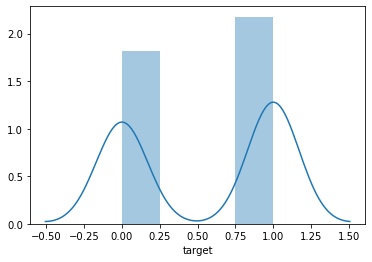

In [7]:
sn.distplot(data['target'])

In [8]:
data.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [9]:
y = data['target']
x = data.drop('target', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
pd.crosstab(data['sex'], data['target'])

target,0,1
sex,,
0,24,72
1,114,93


# Interpretation

## Interpretable models

### Logistic Regression

In [11]:
model = LogisticRegression(random_state=10)
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  0.8512396694214877
Recall on train:    0.9097744360902256
Accuracy on test:   0.8688524590163934
Recall on test:     0.875


In [13]:
d = {'feature': x_train.columns, 'meaning': cols_meaning[:-1], 'coefficient': model.coef_[0], 'odds': np.exp(model.coef_[0])}
df = pd.DataFrame(index=cols_index[:-1], data=d)
df.sort_values(by='odds', ascending=False)

,feature,meaning,coefficient,odds
x2,cp,chest pain type,0.788964,2.201114
x10,slope,the slope of the peak exercise ST segment,0.663470,1.941517
x6,restecg,resting electrocardiographic results,0.524790,1.690104
x5,fbs,fasting blood sugar > 120 mg/dl (1 = true; 0 = false),0.129914,1.138730
x7,thalach,maximum heart rate achieved,0.026051,1.026393
x0,age,age of patient,0.006637,1.006659
x4,chol,serum cholesterol in mg/dl,-0.002346,0.997657
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital),-0.012576,0.987503
x9,oldpeak,ST depression induced by exercise relative to rest,-0.613355,0.541531
x11,ca,number of major vessels (0-3) colored by fluoroscopy,-0.771983,0.462096


age: one unit increase, 0.7% higher chance
sex: binary, females have a higher chance
cp: one unit increase, 120% higher chance
trestbps: one unit increase, 1.3% lower chance
chol: one unit increase, 0.2% lower chance
fbs: binary, 14% higher chance if true than when false
restecg: one unit increase, 69% higher chance
thalach: one unit increase, 2.6% higher chance
exang: binary, higher chance if false
oldpeak: one unit increase, 46% lower chance
slope: one unit increase, 94% higher chance
ca: one unit increase, 54% lower chance
thal: one unit increase, 58% lower chance

### Decision Tree Classifier

In [14]:
model = DecisionTreeClassifier(random_state=22)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=22, splitter='best')

In [15]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  1.0
Recall on train:    1.0
Accuracy on test:   0.8524590163934426
Recall on test:     0.78125


What's wrong with this tree?

In [16]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [17]:
tree_to_code(model, x_train.columns)

def tree(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
  if cp <= 0.5:
    if ca <= 0.5:
      if exang <= 0.5:
        if thal <= 2.5:
          if chol <= 316.5:
            return [[ 0. 18.]]
          else:  # if chol > 316.5
            if slope <= 1.5:
              return [[0. 1.]]
            else:  # if slope > 1.5
              return [[1. 0.]]
        else:  # if thal > 2.5
          if restecg <= 0.5:
            return [[3. 0.]]
          else:  # if restecg > 0.5
            if age <= 41.0:
              return [[1. 0.]]
            else:  # if age > 41.0
              return [[0. 3.]]
      else:  # if exang > 0.5
        if oldpeak <= 0.7000000178813934:
          if slope <= 1.5:
            if thalach <= 147.5:
              return [[3. 0.]]
            else:  # if thalach > 147.5
              return [[0. 1.]]
          else:  # if slope > 1.5
            if age <= 44.0:
              return [[1. 0.]]
            else:  # if a

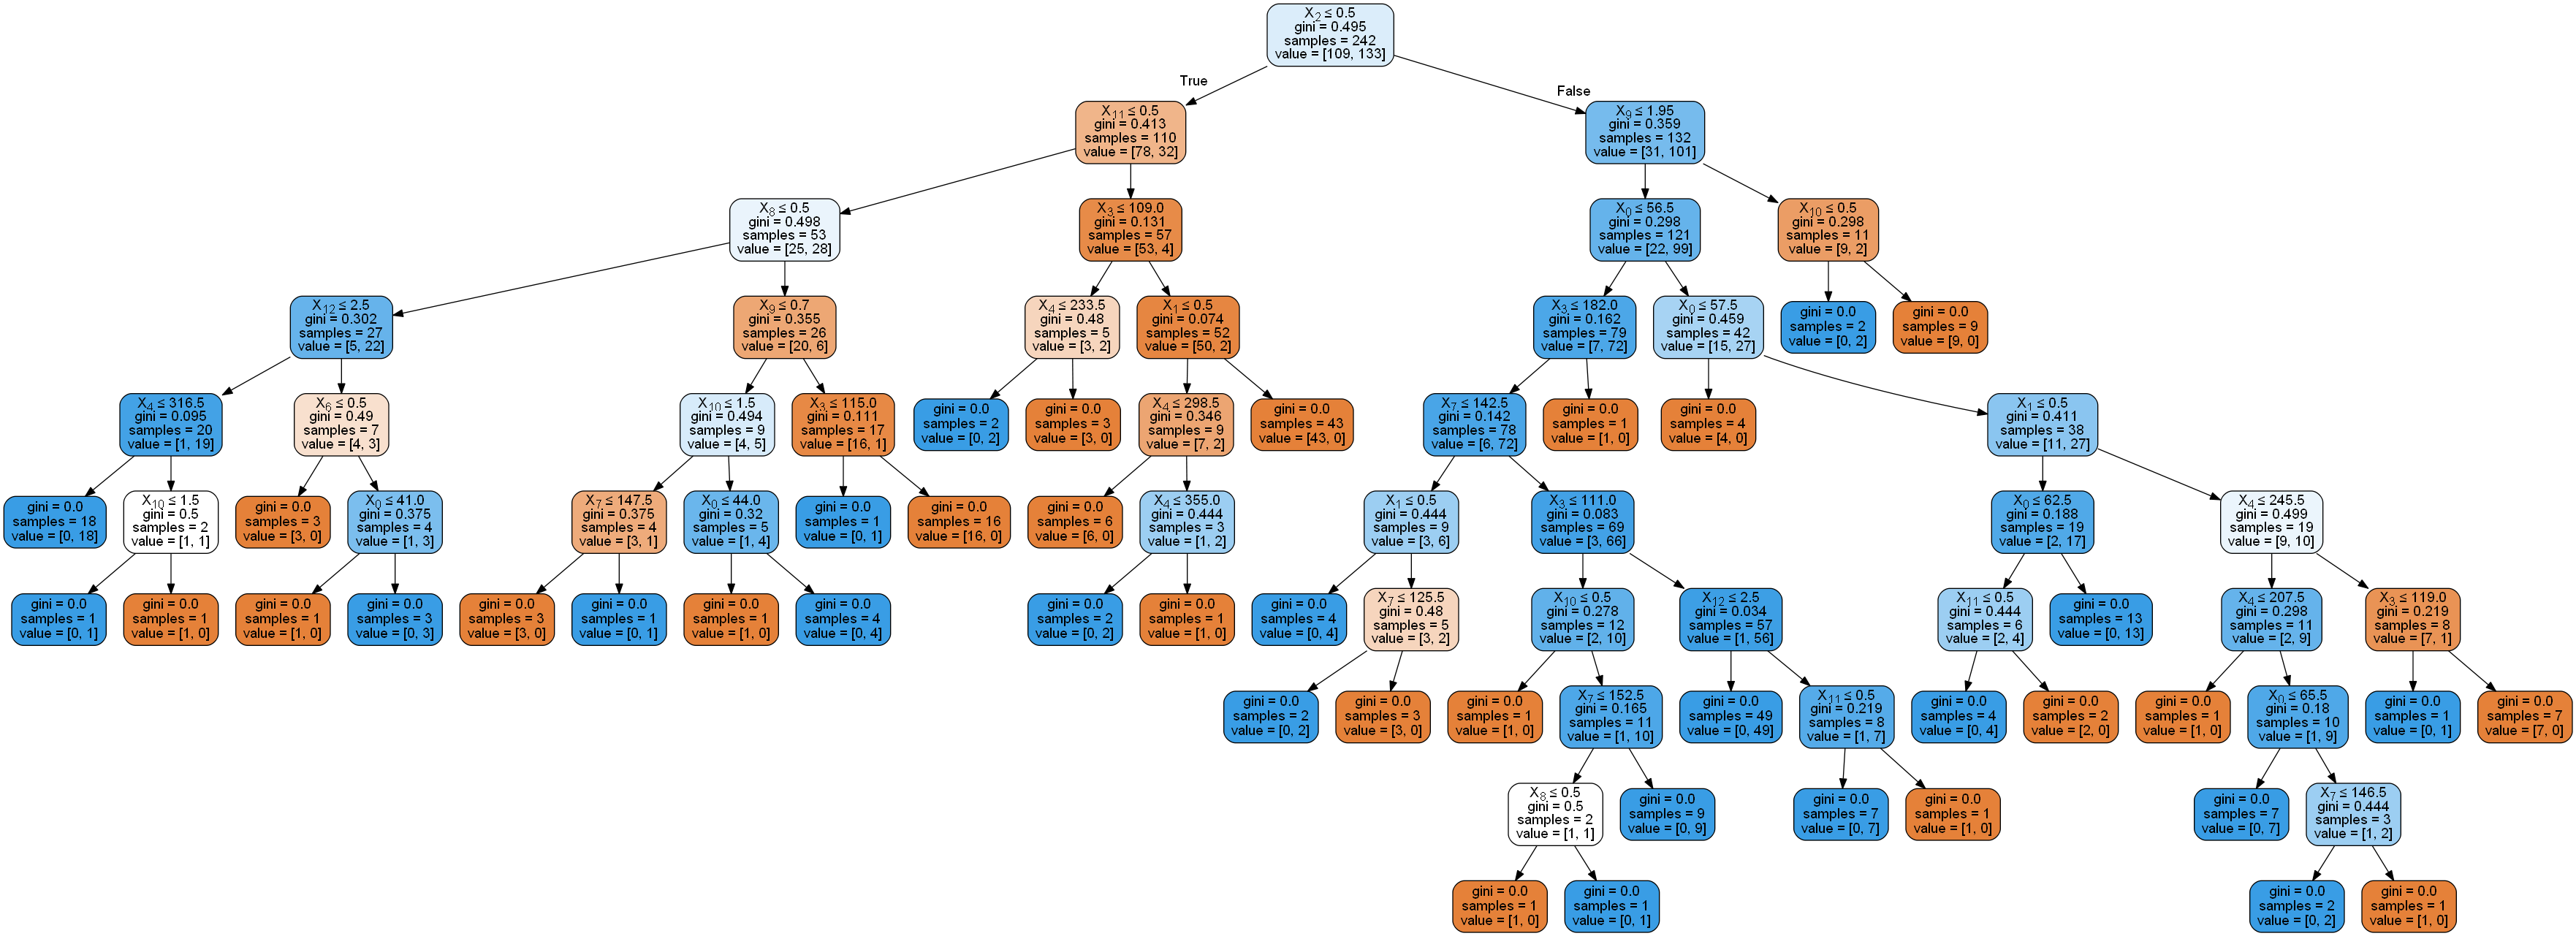

In [18]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [19]:
x_test.join(y_test)[0:1]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1,0


In [20]:
df['importances_tree'] = model.feature_importances_
df.sort_values('importances_tree', ascending=False)

,feature,meaning,coefficient,odds,importances_tree
x2,cp,chest pain type,0.788964,2.201114,0.225263
x11,ca,number of major vessels (0-3) colored by fluoroscopy,-0.771983,0.462096,0.133084
x4,chol,serum cholesterol in mg/dl,-0.002346,0.997657,0.102953
x0,age,age of patient,0.006637,1.006659,0.100892
x9,oldpeak,ST depression induced by exercise relative to rest,-0.613355,0.541531,0.092402
x8,exang,exercise induced angina (1 = yes; 0 = no),-0.891962,0.409851,0.083767
x7,thalach,maximum heart rate achieved,0.026051,1.026393,0.061675
x10,slope,the slope of the peak exercise ST segment,0.663470,1.941517,0.059530
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital),-0.012576,0.987503,0.057994
x1,sex,"1 = male, 0 = female",-1.356947,0.257445,0.041015


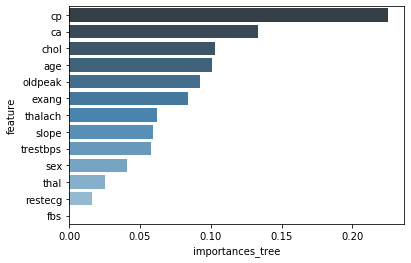

In [21]:
sn.barplot(x="importances_tree", y="feature", data=df.sort_values('importances_tree', ascending=False), palette="Blues_d")

## Model-agnostic methods

In [22]:
model = RandomForestClassifier(n_estimators=1000, random_state=1, max_depth=5)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [23]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  0.9504132231404959
Recall on train:    0.9849624060150376
Accuracy on test:   0.8688524590163934
Recall on test:     0.90625


In [24]:
df['importances_rf'] = model.feature_importances_

In [25]:
df.sort_values('importances_rf', ascending=False)

,feature,meaning,coefficient,odds,importances_tree,importances_rf
x11,ca,number of major vessels (0-3) colored by fluoroscopy,-0.771983,0.462096,0.133084,0.149635
x9,oldpeak,ST depression induced by exercise relative to rest,-0.613355,0.541531,0.092402,0.133810
x2,cp,chest pain type,0.788964,2.201114,0.225263,0.128034
x12,thal,3 = normal; 6 = fixed defect; 7 = reversable defect,-0.859126,0.423532,0.025328,0.113033
x7,thalach,maximum heart rate achieved,0.026051,1.026393,0.061675,0.100257
x8,exang,exercise induced angina (1 = yes; 0 = no),-0.891962,0.409851,0.083767,0.083404
x0,age,age of patient,0.006637,1.006659,0.100892,0.077142
x10,slope,the slope of the peak exercise ST segment,0.663470,1.941517,0.059530,0.053875
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital),-0.012576,0.987503,0.057994,0.051795
x4,chol,serum cholesterol in mg/dl,-0.002346,0.997657,0.102953,0.051588


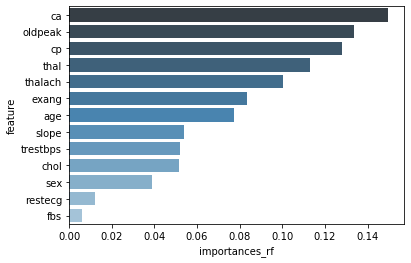

In [26]:
sn.barplot(x="importances_rf", y="feature", data=df.sort_values('importances_rf', ascending=False), palette="Blues_d")

### Permutation Feature Importance

In [27]:
perm = PermutationImportance(model).fit(x_test, y_test)
eli5.show_weights(perm)

Weight,Feature
0.0393 ± 0.0334,x2
0.0328 ± 0.0359,x11
0.0197 ± 0.0245,x12
0.0131 ± 0.0131,x6
0.0131 ± 0.0131,x1
0.0131 ± 0.0482,x7
0.0098 ± 0.0161,x10
0.0098 ± 0.0262,x0
0.0000 ± 0.0207,x8
0 ± 0.0000,x5


### Partial Dependence Plot

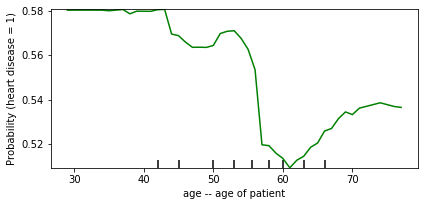

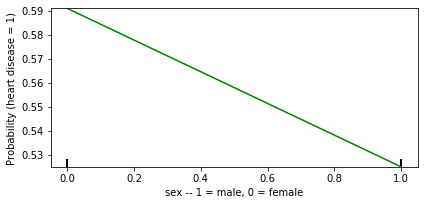

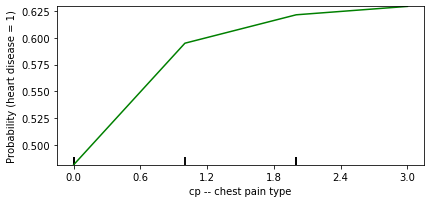

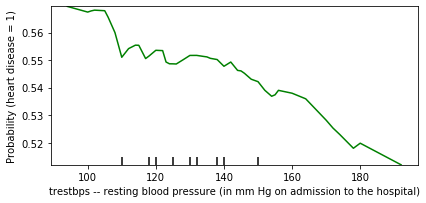

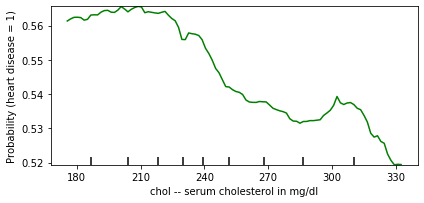

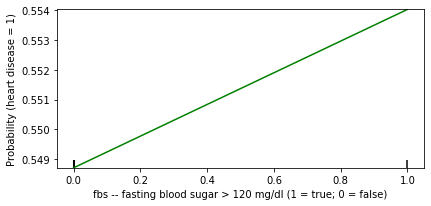

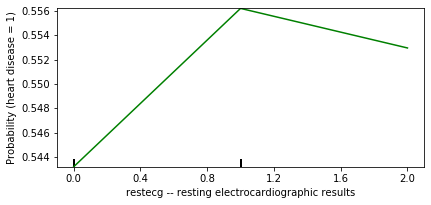

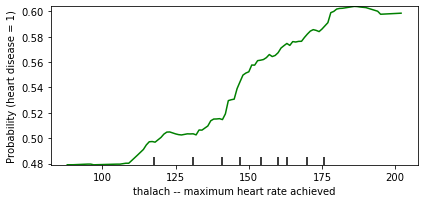

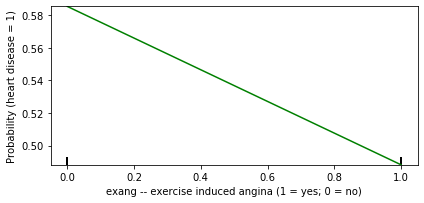

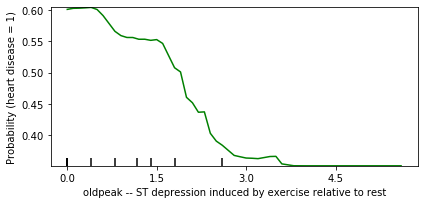

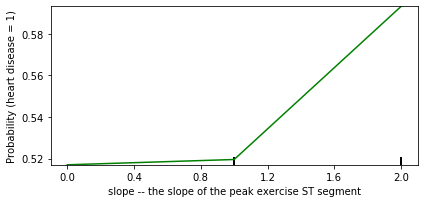

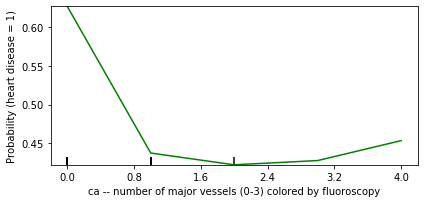

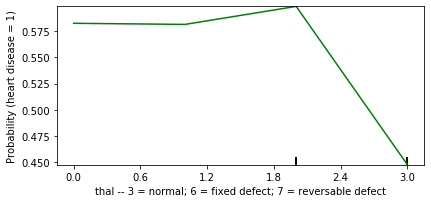

In [28]:
from sklearn.inspection import plot_partial_dependence

for i in range(len(x_train.columns)):
    plot_partial_dependence(model, x_train, [i])
    plt.xlabel(x.columns[i] + ' -- ' + cols_meaning[i])
    plt.ylabel('Probability (heart disease = 1)')
    plt.show()

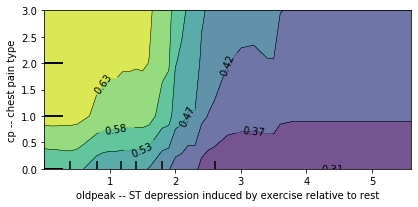

In [29]:
i = 9
j = 2

plot_partial_dependence(model, x_train, [(i,j)])
plt.xlabel(x.columns[i] + ' -- ' + cols_meaning[i])
plt.ylabel(x.columns[j] + ' -- ' + cols_meaning[j])
plt.show()

### Individual Conditional Expectation

,x,display_column,count,target
0,0,sex_0,96,0.750000
1,1,sex_1,207,0.449275


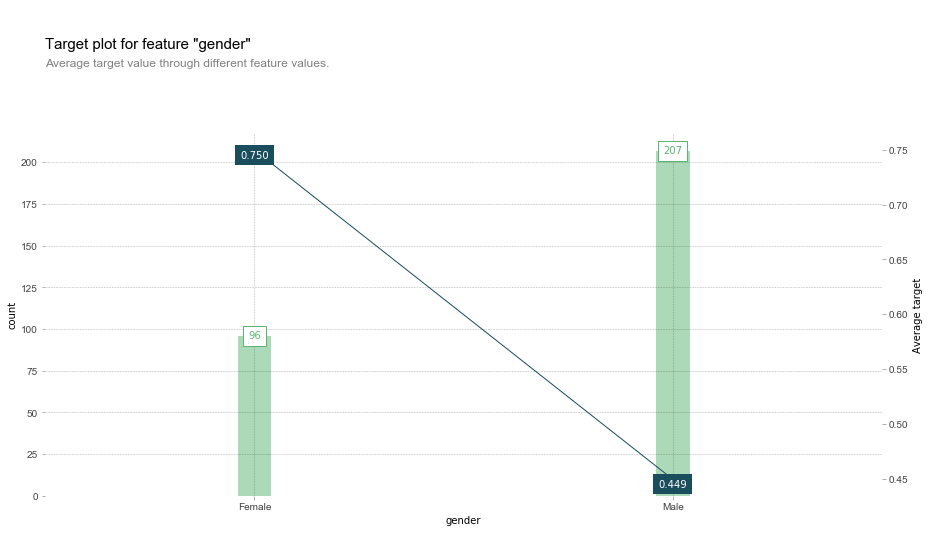

In [30]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='sex', feature_name='gender', target='target'
)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

summary_df

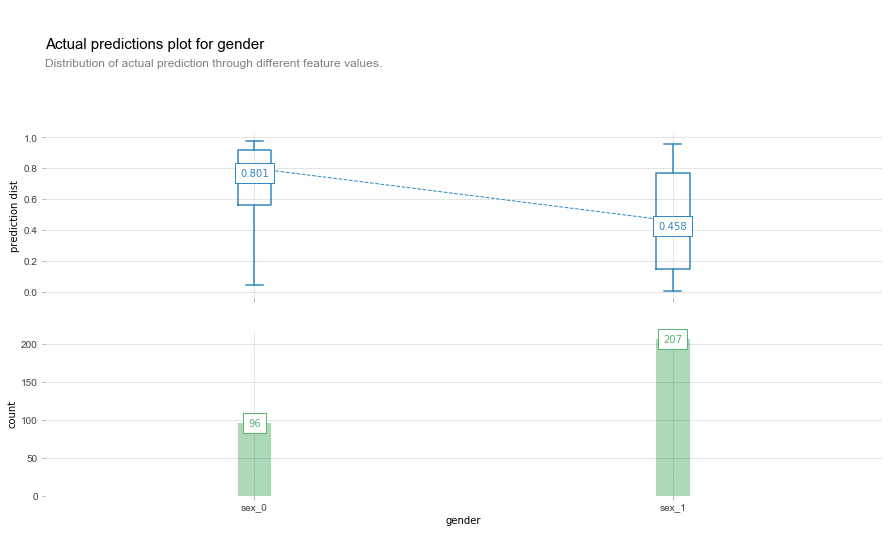

In [31]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model, X=data[df['feature']], feature='sex', feature_name='gender', predict_kwds={}
)

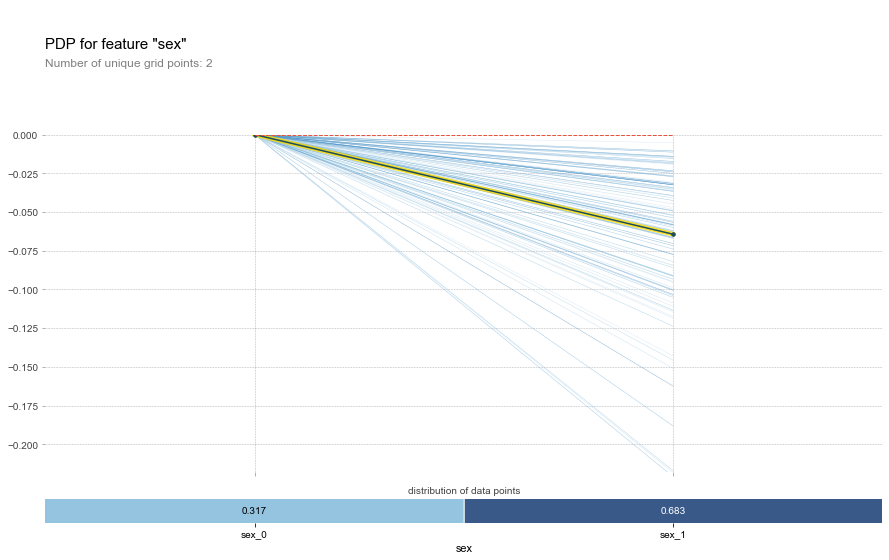

In [32]:
feature = 'sex'

pdp_ = pdp.pdp_isolate(
    model=model, dataset=data, model_features=df['feature'], feature=feature
)

fig, axes = pdp.pdp_plot(pdp_, feature, center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,target
0,0,"[126, 192.56)",126.000000,192.555556,"[0, 11.11)",0.00,11.11,34,0.529412
1,1,"[192.56, 207)",192.555556,207.000000,"[11.11, 22.22)",11.11,22.22,33,0.636364
2,2,"[207, 221.67)",207.000000,221.666667,"[22.22, 33.33)",22.22,33.33,34,0.705882
3,3,"[221.67, 234)",221.666667,234.000000,"[33.33, 44.44)",33.33,44.44,31,0.516129
4,4,"[234, 247)",234.000000,247.000000,"[44.44, 55.56)",44.44,55.56,35,0.657143
5,5,"[247, 263)",247.000000,263.000000,"[55.56, 66.67)",55.56,66.67,33,0.454545
6,6,"[263, 282)",263.000000,282.000000,"[66.67, 77.78)",66.67,77.78,34,0.558824
7,7,"[282, 306.44)",282.000000,306.444444,"[77.78, 88.89)",77.78,88.89,35,0.371429
8,8,"[306.44, 564]",306.444444,564.000000,"[88.89, 100]",88.89,100.00,34,0.470588


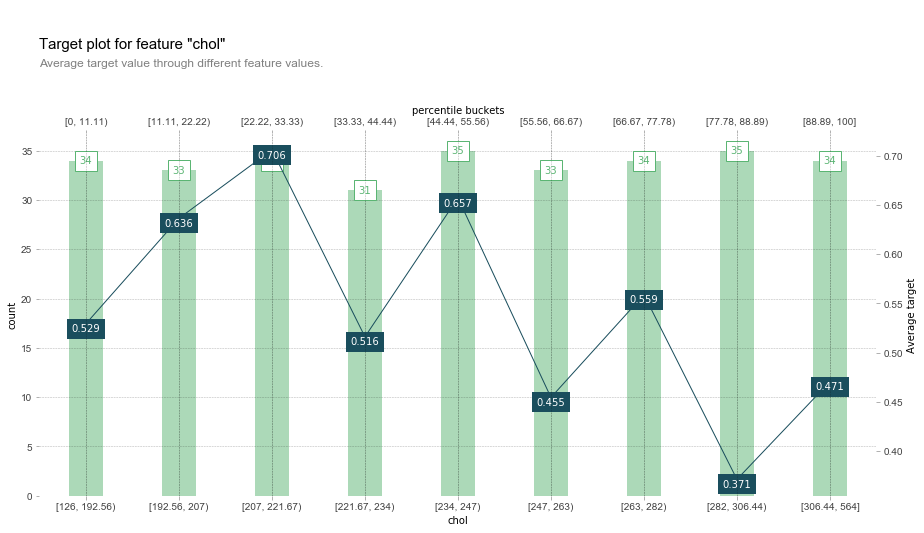

In [33]:
feature = 'chol'

fig, axes, summary_df = info_plots.target_plot(
    df=data, feature=feature, feature_name=feature, target='target', show_percentile=True
)
summary_df

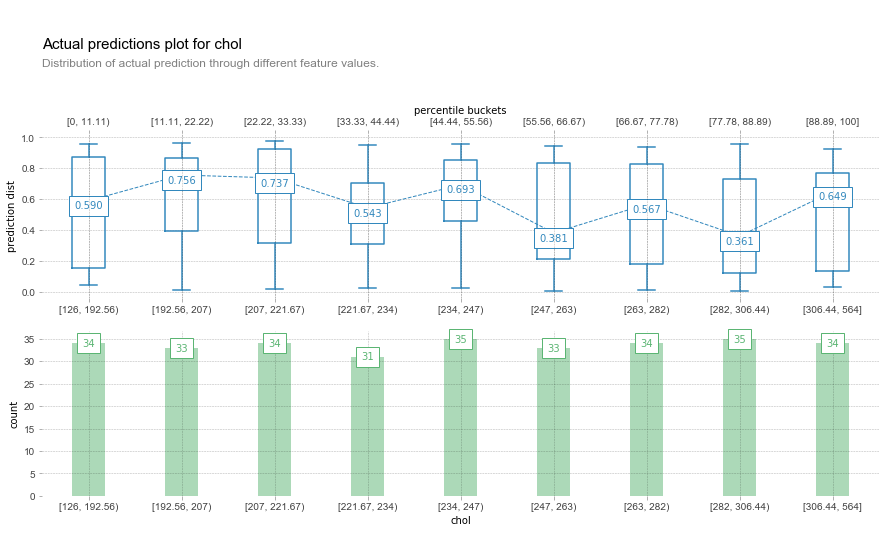

In [34]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model, X=data[df['feature']], feature=feature, feature_name=feature, 
    show_percentile=True, predict_kwds={}
)

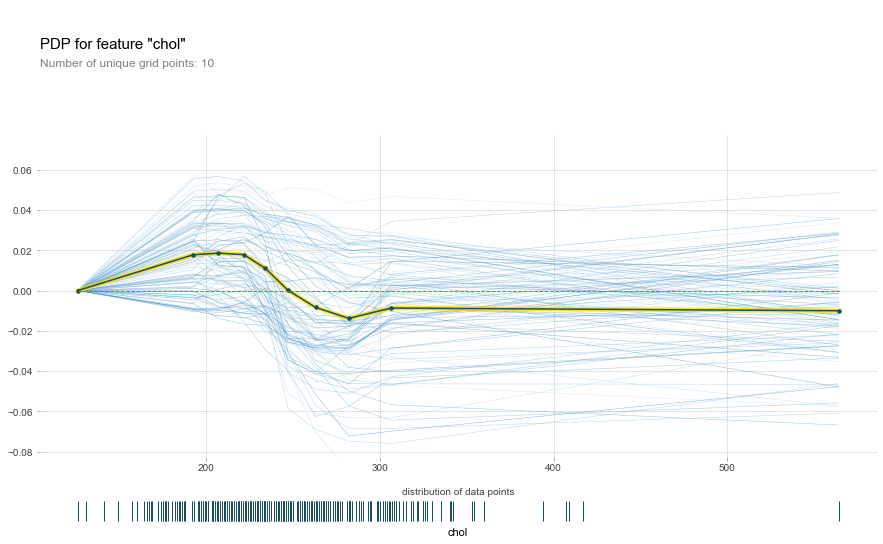

In [35]:
pdp_ = pdp.pdp_isolate(
    model=model, dataset=data, model_features=df['feature'], feature=feature
)

fig, axes = pdp.pdp_plot(pdp_, feature, center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

### LIME

In [36]:
explainer = lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns, class_names=['false', 'true'])

In [37]:
i = 2 #np.random.randint(0, x_test.shape[0])
print('Case:  ' + str(i))
print('Label: ' + str(y_test.iloc[i]))
npxtest = x_test.values
exp = explainer.explain_instance(npxtest[i], model.predict_proba, num_features=13, top_labels=1)

Case:  2
Label: 1


In [38]:
x_test.join(y_test)[2:3]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3,1


In [39]:
exp.show_in_notebook(show_table=True)

### SHAP

In [40]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

i = 1
pred = model.predict(x_test.iloc[i].values.reshape(1,-1))[0]
print('Case:  ' + str(i))
print('Label: ' + str(y_test.iloc[i]))
print('Pred:  ' + str(pred))
shap.force_plot(explainer.expected_value[y_test.iloc[i]], shap_values[1][i], x_test.iloc[i], feature_names=x_train.columns)

Case:  1
Label: 0
Pred:  1


In [41]:
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test, feature_names=x_train.columns)

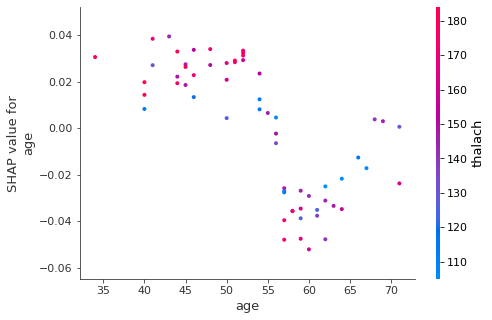

In [42]:
shap.dependence_plot("age", shap_values[1], x_test)

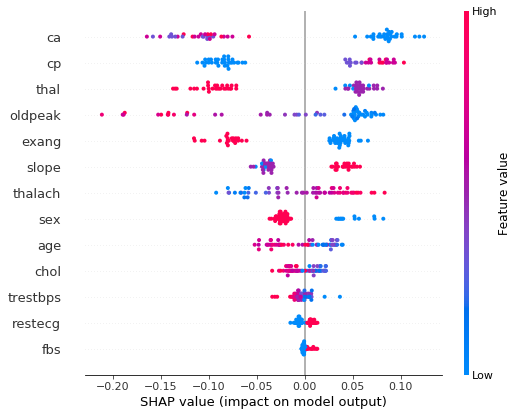

In [43]:
shap.summary_plot(shap_values[1], x_test)

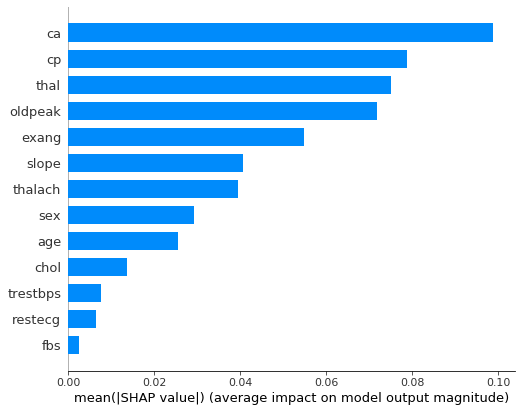

In [44]:
shap.summary_plot(shap_values[1], x_test, plot_type="bar")